# Final Project
#### Uncertainty Quantification and Probabilistic Machine Learning Independent Study (Fall 2022)
#### By Brad Shook

This notebook offers an overview of the main topics that I learned throughout my independent study. Additionally, comparisons are made between the methods and practical applications of each are discussed. 

The contents are as follows:
- Aleatoric Uncertainty
- Epistemic Uncertainty
- Heteroscedastic vs. Homoscedastic Data
- Synthesizing Regression Data
- Bayesian Neural Networks
    - Without Uncertainty Quantification
    - Capturing Aleatoric Uncertainty
    - Capturing Epistemic Uncertainty
    - Capturing Aleatoric AND Epistemic Uncertainty
    - Practical Applications of Bayesian Neural Networks
- Ensembling
    - Epistemic Uncertainty with Random Weight Initialization
    - Epistemic Uncertainty with Random Weight Initialization AND Bootstrapping
    - Aleatoric AND Epistemic Uncertainty with Random Weight Initialization
    - Aleatoric AND Epistemic Uncertainty with Random Weight Initialization AND Bootstrapping
    - Practical Applications of Ensembling
- Dropout
    - Monte Carlo (MC) Dropout
    - Concrete Dropout
    - Practical Applications of Dropout
- Gaussian Processes (GPs)
    - GP with Linear Kernel
    - Practical Applications of GPs
- Normalizing Flows
    - Practical Applications of Normalizing Flows
- Implicit Quantile Networks (IQNs)
    - Practical Applications of IQNs

Note: 
- The names 'inputs' and 'outputs' are given to x and y values. This is so the reader thinks of these concepts in terms of inputs and outputs rather than x and y which imply each is 1-dimensional. most interesting data will have inputs and outputs with high dimensions.  

In [2]:
import sys
sys.path.append('../../normalizing-flows')
%matplotlib inline
from pprint import pprint
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from IPython.display import Image
from concretedropout.tensorflow import ConcreteDenseDropout, get_weight_regularizer, get_dropout_regularizer

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from normalizing_flows.flows import Flow, affine
from normalizing_flows.models.losses import kl_divergence_normal
from tqdm import tqdm

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

tfd = tfp.distributions
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Aleatoric Uncertainty

Aleatoric uncertainty, or data uncertainty, refers to the uncertainty inherent to the data. This type of uncertainty is irreducible. 

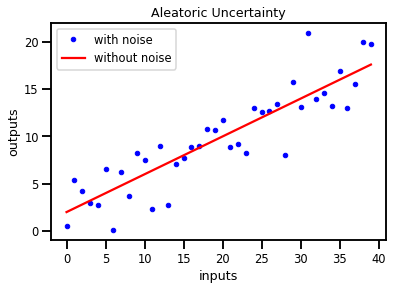

In [241]:
n = 40
inputs = np.arange(n)
noise = np.random.normal(loc = 0, scale = 3, size = (n,))

outputs_with_noise = .4 * inputs + 2 + noise
outputs_without_noise = .4 * inputs + 2
plt.plot(inputs,outputs_with_noise, 'b.', label = 'with noise')
plt.plot(inputs,outputs_without_noise, label = 'without noise', c = 'red')
plt.xlabel('inputs')
plt.ylabel('outputs')
plt.title('Aleatoric Uncertainty')
plt.legend()

In the above cell, we generate one set of outputs from a linear function, $outputs = (.4\ * inputs)\ +\ 2$. Then, we generate a second set of outputs with that same linear function, but with noise added. The noise added is randomly distributed according to a Gaussian distribution with a mean of 0 and a standard deviation of 3. When we plot each set of outputs, we can visually see how noise affects the outputs, and in turn, the aleatoric uncertainty. The variation in the outputs is the aleatoric uncertainty.

The previous example operated under the assumption that the outputs were distributed according to a Gaussian, but for most datasets, we will have no prior knowledge about the distribution of the outputs. Methods that quantify aleatoric uncertainty operate under different assumptions, and these assumptions will be detailed in each method's section

## Epistemic Uncertainty

Epistemic uncertainty, or model uncertainty, refers to the uncertainty inherent to your model and its parameters. This type of uncertainty is reducible if you train on more and more training data. 

Suppose you have some data that you are trying to model. For that data, there are many ways of modeling it correctly, however, it was only generated from a single true function. Thus, the variance in the distribution of feasible models captures the epistemic uncertainty.

High epistemic uncertainty shows up for inputs where there are unknown outputs, as demonstrated by the below example (image credit to Huy Nguyen https://everyhue.me/posts/why-uncertainty-matters/).  

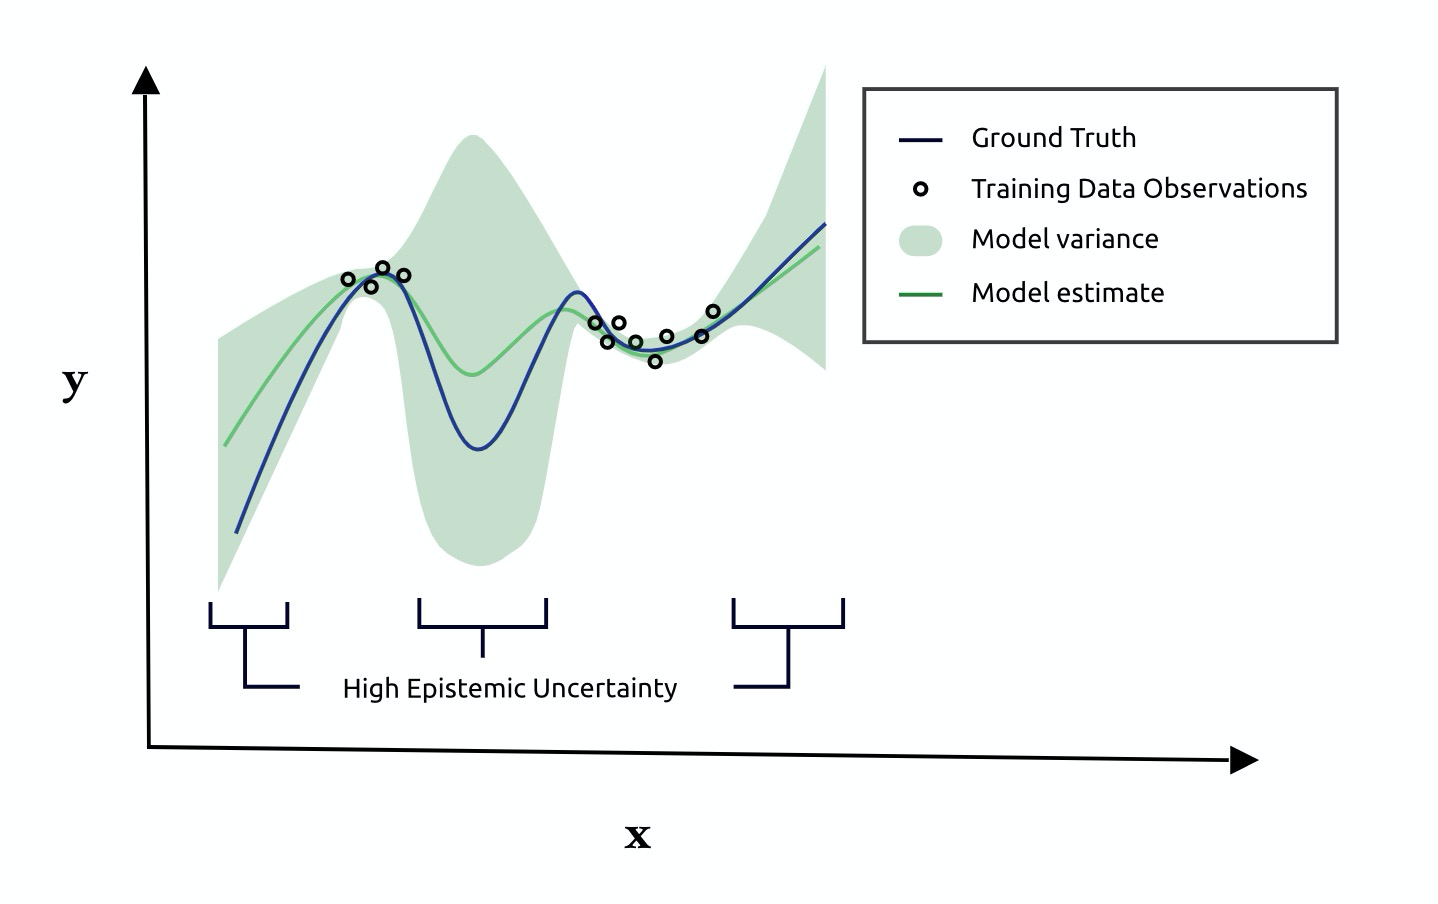

In [242]:
Image(filename='images/epistemic_uncertainty_example.png', width = 700, height = 300) 

## Heteroscedastic vs. Homoscedastic Data

Heteroscedastic data refers to data whose variance of outputs changes as a function of inputs. Homoscedastic data refers to data whose variance of outputs does not change as a function of inputs. 

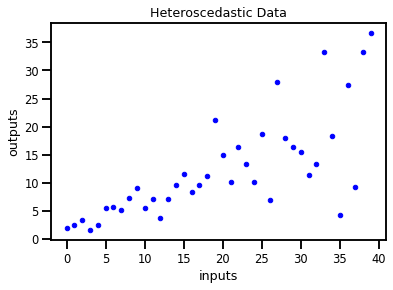

In [243]:
# Heteroscedastic Data
n = 40
inputs = np.arange(n)
noise = np.random.normal(loc = 0, scale = 3, size = (n,))
total_noise = noise * (inputs * .1)
outputs_with_noise = .4 * inputs + 2 + total_noise
plt.plot(inputs,outputs_with_noise, 'b.');
plt.xlabel('inputs');
plt.ylabel('outputs');
plt.title('Heteroscedastic Data');

In the above code, we once again generate data from a linear function with noise added. When noise is added, it is added as a function of the inputs: $total\_noise = noise * (inputs * .1)$. Thus, as $inputs$ increase in value, so does the $total\_noise$ in the $outputs$. Therefore, this data is heteroscedastic. 

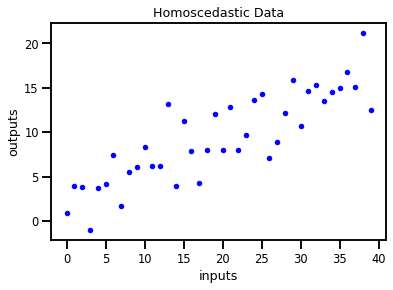

In [244]:
# Homoscedastic Data
n = 40
inputs = np.arange(n)
noise = np.random.normal(loc = 0, scale = 3, size = (n,))
outputs_with_noise = .4 * inputs + 2 + noise
outputs_without_noise = .4 * inputs + 2
plt.plot(inputs,outputs_with_noise, 'b.');
plt.xlabel('inputs');
plt.ylabel('outputs');
plt.title('Homoscedastic Data');

In the above code, we generate data from the same linear function, but this time, the noise that is added is NOT a function of the inputs. Thus, the variance of the outputs is the same for every input and the data is homoscedastic.

## Synthesizing data

In this section, we generate heteroscedastic regression data. 

In [245]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

outputs, inputs, inputs_tst = load_dataset()

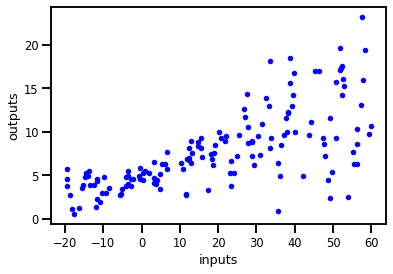

In [246]:
plt.plot(inputs,outputs, 'b.')
plt.xlabel('inputs');
plt.ylabel('outputs');

## Bayesian Neural Networks

The following code in this section has been adapted from TensorFlow's tutorial on probabilistic regression: https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression, https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html.

In [247]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

### Without Uncertainty Quantification

Let's create a model that does not quantify any uncertainty:

In [248]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

model.fit(inputs, outputs, epochs=1000, verbose=False);
model.summary()

[print(np.squeeze(w.numpy())) for w in model.weights];

Model: "sequential_819"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_444 (Dense)            (None, 1)                 2         
_________________________________________________________________
distribution_lambda_412 (Dis multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
0.13141371
5.1273165


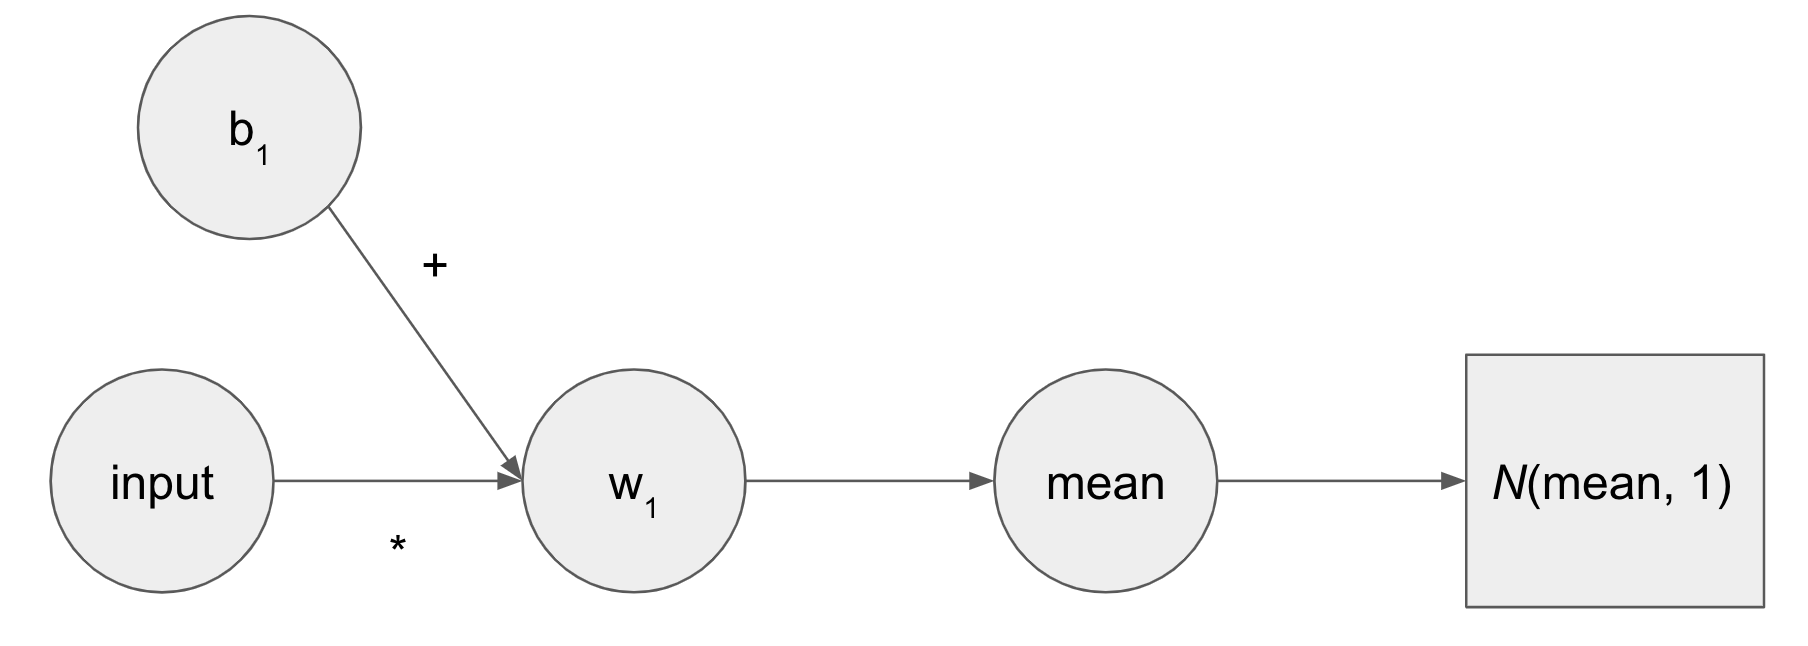

In [3]:
Image(filename='images/fixed_std_nn.png', width = 700, height = 300) 

In the above code, we are creating a neural network model that has a single input and output. There are two parameters in the model, $w_1$ and $b_1$. These parameters and the architecture of the network define a linear function: $mean = w_1 * input + b_1$. The $mean$ is then used to define a Gaussian distribution with a fixed standard deviation of 1. The output of the model is that Gaussian distribution. You can see the computational graph of this model in the image above. 

After creating the model, we optimize it to minimize the negative log likelihood $-log p(y | \theta)$. After the optimization, we can see that the neural network determined that the optimal parameter values were $w_1 \approx 5.1$ and $b_1 \approx 0.13$. This means that the neural networks believes that the data was generated according to the function $output \approx 5.1 * input + 0.13$. 

The current model is assuming that the outputs are randomly distributed according to a Gaussian. Additionally, since we give that Gaussian a fixed standard deviation, we are assuming that the data is homoscedastic and the standard deviation is always 1. Due to how we've constructed the model architecture, we are also assuming that the data is generated from a linear function.

We can generate an output via the below code:

In [249]:
gaussian_preds = model(inputs_tst)

Let's take a look at what the output actually is.

In [250]:
gaussian_preds

<tfp.distributions.Normal 'sequential_819_distribution_lambda_412_Normal' batch_shape=[150, 1] event_shape=[] dtype=float32>

The above code output shows that the output of the model is 150 Gaussian distributions. Each of these 150 Gaussians have a mean corresponding to one of the 150 inputs that we passed to the model. 

What happens if we sample from the Gaussian distribution?

Shape of samples: (150, 1)


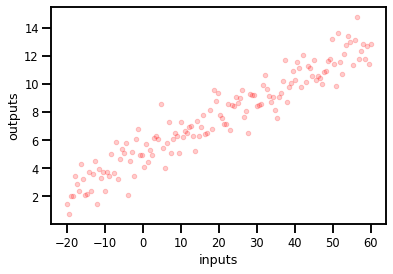

In [251]:
samples = gaussian_preds.sample()
print(f'Shape of samples: {samples.shape}')
plt.plot(inputs_tst, samples, 'r.', alpha = 0.2);
plt.xlabel('inputs');
plt.ylabel('outputs');

In the above plot, we can see that when we sample from the Gaussian distributions, 150 outputs are sampled. Each of these outputs is sampled by a Gaussian distribution with a unique mean. 

Given that each Gaussian distribution has a unique mean, why don't we plot each of these means?

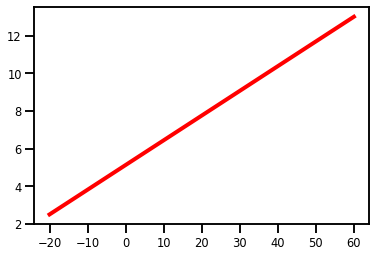

In [252]:
plt.plot(inputs_tst, gaussian_preds.mean(), c = 'red', linewidth = 4);

How are these means determined? Well, because $w_1 = 5.1$ and $b_1 = 0.13$, our hidden layers produce means according to $mean = 5.1 * input + 0.13$.

Let's combine all this data into a single plot:

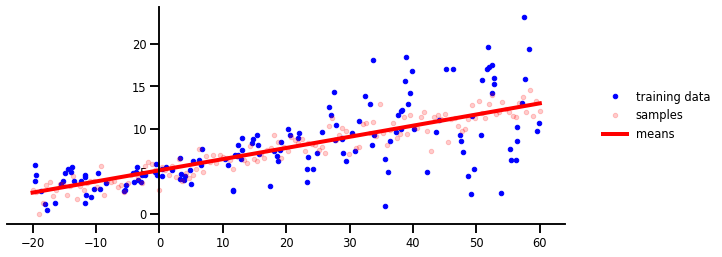

In [253]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[10, 4])  # inches
plt.plot(inputs, outputs, 'b.', label='training data');
plt.plot(inputs_tst, gaussian_preds.sample(), 'r.', alpha = 0.2, label='samples');
plt.plot(inputs_tst, gaussian_preds.mean(), c = 'red', linewidth = 4, label='means');

plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/bnn_with_no_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, we can see the training data, samples that were generated from the Gaussian distributions, and the means of those same Gaussians.

We see that the neural networks does a mediocre job of modeling the full training data. Specifically, there are some issues:

1. The model is deterministic, meaning that everytime that we put through a specific input, we will be given the same mean and thus the same Gaussian. 
2. The model does not capture any uncertainty. 
3. The model assumes the data is homoscedastic resulting in the variance of outputs being 1 for each input, however, as we can see, it is heteroscedastic data.

So how can we quantify the aleatoric uncertainty?

### Capturing Aleatoric Uncertainty

In order to capture the aleatoric uncertainty, we need to model the outputs of our model as a probability distribution. In the previous example, we modeled the outputs as a Gaussian distribution, but we used a fixed standard deviation. There is nothing stopping us from parameterizing the standard deviation, so let's try that. 

In [254]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(2, name = 'dense_1'),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(inputs, outputs, epochs=1000, verbose=False);
model.summary()

kernel_params = 0
bias_params = 0
for i,w in enumerate(model.weights):
    if i == 0:
        [print(f'kernel: {np.squeeze(w.numpy())}')]
        kernel_params = len(np.squeeze(w.numpy()))
    else: 
        [print(f'bias: {np.squeeze(w.numpy())}')]
        bias_params = len(np.squeeze(w.numpy()))

print(f'total number of parameters: {kernel_params + bias_params}')

Model: "sequential_820"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_413 (Dis multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
kernel: [0.12117918 0.9546023 ]
bias: [5.195355  4.8402224]
total number of parameters: 4


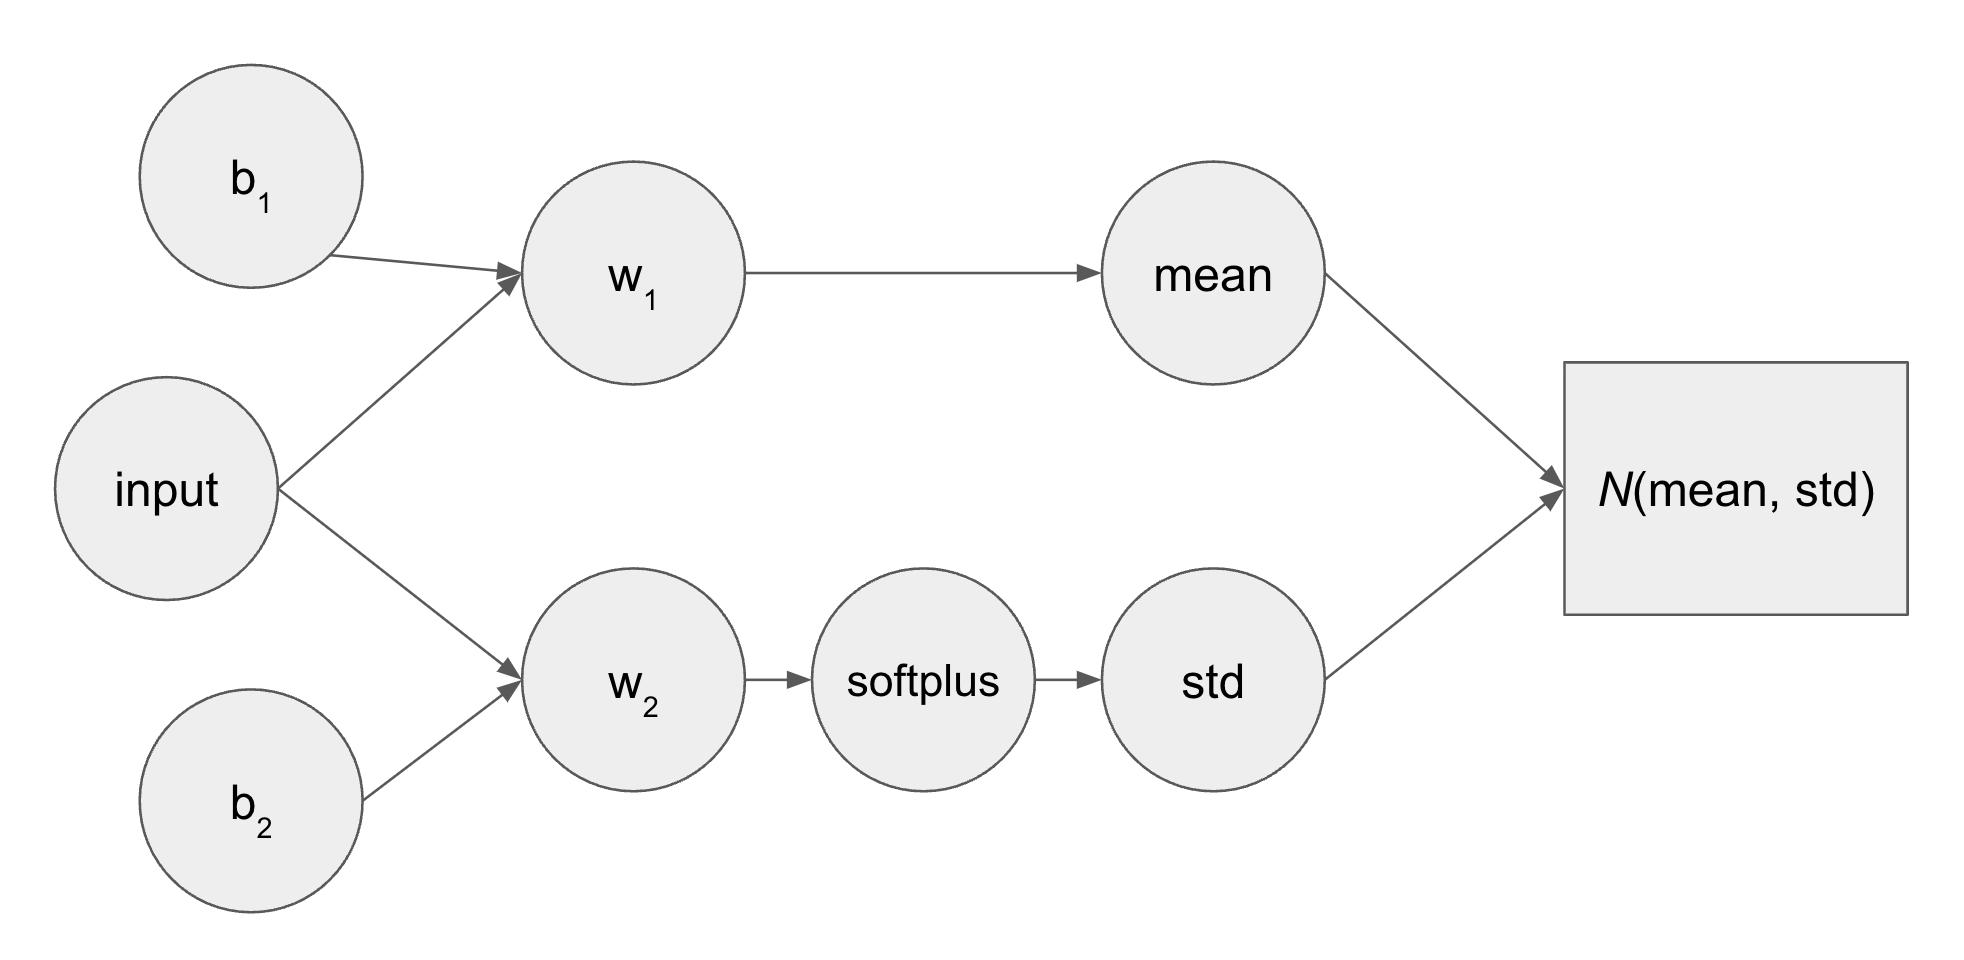

In [175]:
Image(filename='images/non_fixed_std_nn.png', width = 700, height = 300) 

In the above code, we define a model with a single input, a hidden layer with 2 nodes each with a weight and bias, and a Gaussian distribution as output. Given this model architecture, the parameters are $w_1$, $b_1$, $w_2$, and $b_2$. The parameters $w_1$ and $b_1$ parameterize the mean of the Gaussian distribution while $w_2$ and $b_2$ parameterize the standard deviation. The computational graph of this model is shown in the image above.

After creating the model, we optimize the parameters to minimize the negative log likelihood, $-log p(y|\theta)$. The optimization process finds that the mean of the Gaussian should be generated as $mean = 5.1 * inputs + 0.13$. If you recall from the prior section, those same parameters were found. As for the standard deviation, it was found to be generated as $std = softplus(0.05 * (15.1 * inputs + 1)) + 1e-3$.

Like the previous model, this model assumes that the outputs are randomly distributed accoording to a Gaussian distribution. However, unlike the previous model, this model makes no assumptions about the standard deviation of that Gaussian and allows for the model to determine the heteroscedasticity of the data through the optimization process.

Now, when we generate outputs from the model, the outputs will have heteroscedasticity and we can capture the aleatoric uncertainty.

Let's see what the output of the model is.

In [259]:
gaussian_preds = model(inputs_tst)
print(gaussian_preds)

tfp.distributions.Normal("sequential_820_distribution_lambda_413_Normal", batch_shape=[150, 1], event_shape=[], dtype=float32)


We can see that the type of output is the same as the previous model; there are 150 Gaussian distributions corresponding to each input. Contrary to the previous model, however, each of these Gaussians have a unique mean and standard deviation.

Let's sample from these Gaussians:

Shape of samples: (150, 1)


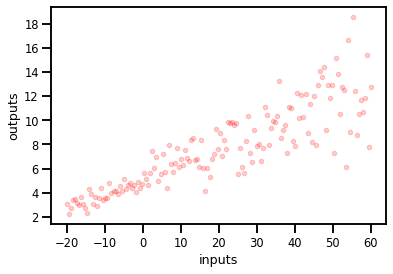

In [260]:
samples = gaussian_preds.sample()
print(f'Shape of samples: {samples.shape}')
plt.plot(inputs_tst, samples, 'r.', alpha = 0.2);
plt.xlabel('inputs');
plt.ylabel('outputs');

In the above plot, we can see that the samples generated do seem to originate from Gaussians with different means and standard deviations.

What happens if we plot the means and standard deviations from the Gaussians? Let's see:

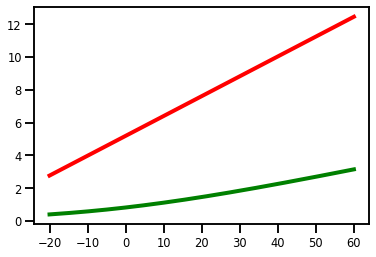

In [261]:
m = gaussian_preds.mean()
s = gaussian_preds.stddev()

plt.plot(inputs_tst, m, 'r', linewidth=4, label='means');
plt.plot(inputs_tst, s, 'g', linewidth=4, label='means');

Okay, we can see that there is indeed a single mean and standard deviation for each Gaussian.

Now, we can plot the training data, the samples, the mean, and the mean $\pm$ 2 standard deviations!

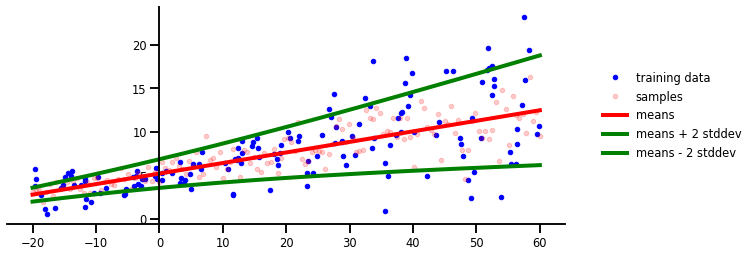

In [262]:
plt.figure(figsize=[10, 4]) 
plt.plot(inputs, outputs, 'b.', label='training data');

m = gaussian_preds.mean()
s = gaussian_preds.stddev()

plt.plot(inputs_tst, gaussian_preds.sample(), 'r.', alpha = 0.2, label='samples');
plt.plot(inputs_tst, m, 'r', linewidth=4, label='means');
plt.plot(inputs_tst, m + 2 * s, 'g', linewidth=4, label=r'means + 2 stddev');
plt.plot(inputs_tst, m - 2 * s, 'g', linewidth=4, label=r'means - 2 stddev');

plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/bnn_with_aleatoric_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, we can see that the generated samples are much more representative of the training data than the model with a fixed standard deviation. Moreover, we see that the samples are heteroscedastic. Another aspect of this model to note is that it is deterministic like our previous model, every input defines a single Gaussian. 

We've now created a neural network that models the aleatoric uncertainty. However, the model does not capture the epistemic uncertainty. We will now create a model that quantifies the epistemic uncertainty. 

### Capturing Epistemic Uncertainty

In the previous examples, we have used single values to represent the weights in the neural networks. Due to this, the network produces deterministic outputs. But what if we modeled each weight as a probability distribution and sample from these distributions every forward pass through the network. Well, that is the idea behind bayesian neural networks. 

The issue with this approach is that computing the true posterior of bayesian neural networks is usually intractable. Thus, approximation techniques are often employed. One such approximation technique is known as variational inference. 

In variational inference, we place a trainable prior on the weights, $p(w)$, and create a trainable surrogate posterior, $q(w|\theta)$, where $w$ are the weights of the neural network and $\theta$ parameterizes the distribution of the weights. Then, we attempt to find the parameters, $\theta$, that minimize the Kullback-Leibler (KL) divergence between $p(w|x,y)$ and $q(w|\theta)$. For more information on Bayesian neural networks and variational inference, check out: https://arxiv.org/pdf/1505.05424.pdf and http://krasserm.github.io/2019/03/14/bayesian-neural-networks/.

In the below code blocks, we will create a bayesian neural network that uses variational inference to approximate the true posterior, $p(w|x,y)$. 

In [263]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
# Normal Distributions have two parameters: the mean and the covariance matrix.
# So our posterior will have a trainable mean and a trainable covariance matrix.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size # 
  c = np.log(np.expm1(1.)) # 0.54...
    
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype), # Returns a TF variable when called, regardless of input
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In the above code, we set $n$ equal to the kernel size plus the bias size. The number of nodes in the DenseVariational layer determines these sizes. Each node has a kernel (weight) and bias parameter (unless use_bias = False). So, if the DenseVariational layer has 1 node, then $n = 2$ because the kernel size will be 1 and bias size will be 1. In the following examples, we won't set use_bias = False, so we can say that $n$ equals the number of DenseVariational nodes times 2. 
 
We then define the surrogate posterior, $q(w|\theta)$. The surrogate posterior is defined as a multivariate independent Gaussian with $n$ dimensions. Thus, there are $n$ means and $n$ variances. Thus, there are $2n$ trainable parameters for the surrogate posterior.

In [264]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
# The prior represents our belief about which parameters are likely before
# we've seen any data.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size # Depend on the number of nodes in DenseVariational layer
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In the above code, we define the trainable prior, $p(w)$. The trainable prior is defined as a multivariate independent Gaussian with $n$ dimensions, where $n$ is defined in the same way as the previous code snippet. Thus, there are $n$ means and $n$ variances. However, we fix the variances as 1 in the multivariate independent Gaussian. So, there will be $\frac{n+n}{2} = n$ trainable parameters that determine the means for the prior. 


Since the surrogate posterior has $2n$ trainable parameters and the trainable prior has $n$ trainable parameters, then the total number of parameters is $2n + n = 3n$. Thus, with a DenseVariational layer with one node, there are $3 (2 * 1) = 6$ trainable parameters in the network. If the DenseVariational layer had seven nodes, then there would be $3 (2 * 7) = 42$ trainable parameters in the network. 

Now, we can define our bayesian neural network and train it. The model takes in a single input which feeds into a DenseVariational hidden layer. This DenseVariational layer is how we model our weights as distributions and how we tell the model to perform variational inference. Moreover, we define the surrogate posterior and prior to use during variational inference. Then, the output is a Gaussian distribution with a fixed standard deviation of 1 and a mean which is parameterized by the hidden layer's weights. 

When we make a forward pass through this defined model, weights will be sampled from the surrogate posterior, $q(w|\theta)$.

In [265]:
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/inputs.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(inputs, outputs, epochs=1000, verbose=False);
model.summary()

kernel_params = 0
bias_params = 0
for i,w in enumerate(model.weights):
    if i == 0:
        [print(f'kernel: {np.squeeze(w.numpy())}')]
        kernel_params = len(np.squeeze(w.numpy()))
    else: 
        [print(f'bias: {np.squeeze(w.numpy())}')]
        bias_params = len(np.squeeze(w.numpy()))

print(f'total number of parameters: {kernel_params + bias_params}')
gaussian_preds = model(inputs_tst)
print(f'gaussian_preds shape: {gaussian_preds.shape}')
assert isinstance(gaussian_preds, tfd.Distribution)

Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_4 (DenseVa (None, 1)                 6         
_________________________________________________________________
distribution_lambda_414 (Dis multiple                  0         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
kernel: [ 0.14592326  5.137269   -4.0275674  -2.311952  ]
bias: [0.10465344 5.1260433 ]
total number of parameters: 6
gaussian_preds shape: (150, 1)


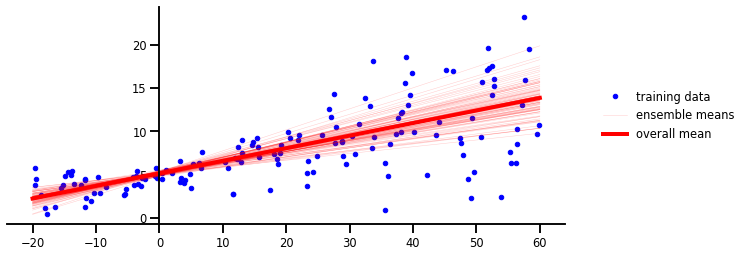

In [266]:
plt.figure(figsize=[10, 4])
plt.clf();
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst) for _ in range(100)]
avgm = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())
  plt.plot(inputs_tst, m, 'r', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(inputs_tst, avgm/len(output_preds), 'r', label='overall mean', linewidth=4)

plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/bnn_with_epistemic_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, each red line represents outputs from the bayesian neural network with weights sampled from $q(w|\theta)$. Each of these forward passes acts as a different model within an ensemble. Thus, we are able to capture the epistemic uncertainty, or model uncertainty. 

At this point, we have shown how to capture aleatoric and epistemic uncertainty individually, but what if we want to capture both these uncertainties simultaneously with the same model? 

### Capturing Aleatoric AND Epistemic Uncertainty

If we want to capture both aleatoric and epistemic uncertainty with a single model, why don't we combine the components of the previous two models? Let's try that!

In [267]:
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/inputs.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(inputs, outputs, epochs=1000, verbose=False);
model.summary()

[print(np.squeeze(w.numpy())) for w in model.weights];

gaussian_preds = model(inputs_tst)
print(f'output_preds shape: {gaussian_preds.shape}')
assert isinstance(gaussian_preds, tfd.Distribution)

Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_5 (DenseVa (None, 2)                 12        
_________________________________________________________________
distribution_lambda_415 (Dis multiple                  0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
[ 0.12834446  2.9834769   5.171479    4.362924   -3.5881376  -0.84861016
 -2.3701887  -0.06801307]
[0.13698317 3.0355802  5.1394997  4.177228  ]
output_preds shape: (150, 1)


In the above code cell, we define a neural network with a single input. Then, we have a DenseVariational hidden layer with two nodes: one for the mean and one for the standard deviation of the output distribution. We use the same surrogate posterior and trainable prior over the weights that we created in the previous section. Since the hidden layer has two nodes, we have 12 total parameters which is twice as many as the 1-node hidden layer in the previous section. The output is defined as a 1-dimensional Gaussian distribution with a mean and standard deviation that is parameterized by the weights of the network. 

By modeling the weights of the network as a distribution, we are able to capture the epistemic, or model, uncertainty. Next, we capture the aleatoric uncertainty by modeling the outputs of the model as a Gaussian with a standard deviation that is a function of the inputs and weights. Therefore, we are able to quantify both the aleatoric and the epistemic uncertainty of the neural network and training data. 

Below, we will make an ensemble of 100 prediction sets from the model. Each of these prediction sets will be generated from different sets of sampled network weights. 

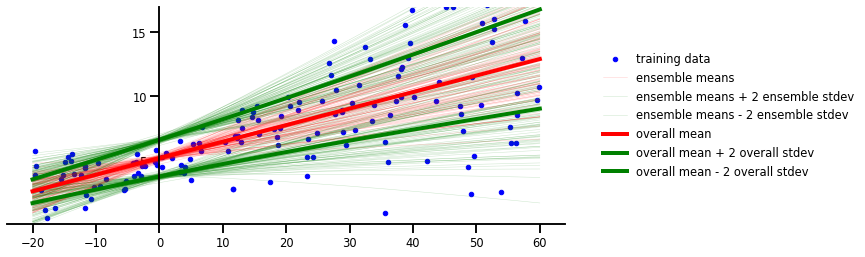

In [268]:
plt.figure(figsize=[10, 4]) 
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst) for _ in range(100)] # Make an ensemble of predictions, acts like 100 different models
avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())
  plt.plot(inputs_tst, m, 'r', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'g', alpha = 0.2, linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'g', alpha = 0.2, linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
  avgs += s

plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/bnn_with_aleatoric_AND_epistemic_uq_predictions.png', bbox_inches='tight', dpi=300)

As we can see in the above plot, our model is able to quantify both aleatoric and epistemic uncertainty.

### Practical Applications of BNNs

Bayesian neural networks, or BNNs, are a powerful tool for quantifying uncertainties. However, these models require large amounts of memory (because each weight has multiple parameters), are hard to optimize, and don't always produce solid results if the surrogate posterior is not representative of the true posterior. 

The following list contains situations where bayesian neural networks can be useful:

- If we are given a small low-dimensional dataset, a BNN can be a good choice for doing UQ. The reason for this is that such a dataset would not require a large model, thus modeling the weights as a distribution would not increase the computational cost by a large amount. 

- If we are given a dataset with outputs whose distribution is known, then a BNN would be a good choice for modeling the aleatoric uncertainty. For example, suppose we are given a dataset whose outputs are distributed according to a beta distribution. Since we know the distribution of the outputs, we know how we should model the distribution of the outputs of our BNN. Thus, we can theoretically determine the beta parameters that capture the aleatoric uncertainty for every input. 

- If one has a proficient amount of computational resources and time, a BNN can be chosen as a UQ method. The reasoning behind this is that when we compare a BNN to a deterministic neural network with the same number of hidden layer nodes, the total number of parameters in the BNN will be much larger than the deterministic neural network because each of the hidden layer nodes within a BNN is parameterized by multiple weights. Due to this difference in the number of parameters, BNNs require more memory than their deterministic counterpart. In terms of time, the process of training a BNN is a more time-consuming task than training a deterministic NN. The reason for this can be seen in the explanations of the previous sections, where BNNs are detailed. 

## Ensembling

Ensembling involves training multiple individual models and combining their outputs. There are a multitude of variations of ensembling. The two main variations are detailed below:

- An ensemble of $n$ models each with a different random weight initialization. By starting each model with a different weight initialization, we expect the optimization process of each model to find diverse local minima, thus producing diverse outputs among the entire ensemble. 
- An ensemble of $n$ models where each is trained on a different bootstrapped/bagged sample of data. A bootstrapped sample is a set of data which is randomly selected with replacement from the original training datsaet and has the same size as the original training dataset. By training each model on a different bootstrapped sample, we expect the optimization process of each model to find diverse local minima, resulting in diverse outputs among the whole ensemble. 

We can combine these two variations as well. Let's see how we can quantify the epistemic uncertainty using ensembling.

### Ensemble: Epistemic Uncertainty with Random Weight Initialization

Below, we build and train 100 models, each with a random initialization and each trained on the same training dataset. 

In [269]:
n_models = 100
model_list = []
for i in range(n_models):
    if i % 5 == 0:
        print(f'Training model {i}...')
    
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(2, name = 'dense_1'),
      tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
    model.fit(inputs, outputs, epochs=1000, verbose=False);
    
    model_list.append(model)

Training model 0...
Training model 5...
Training model 10...
Training model 15...
Training model 20...
Training model 25...
Training model 30...
Training model 35...
Training model 40...
Training model 45...
Training model 50...
Training model 55...
Training model 60...
Training model 65...
Training model 70...
Training model 75...
Training model 80...
Training model 85...
Training model 90...
Training model 95...


In the below cell, we generate a set of outputs from each model in the ensemble. Each of these sets of outputs is referred to an ensemble mean.

In [270]:
output_preds = [model(inputs_tst) for model in model_list]

Then, we can plot each of these ensemble means. In addition, we can take the mean of these ensemble means to get the mean of the overall ensemble, which we will calll the overall mean. 

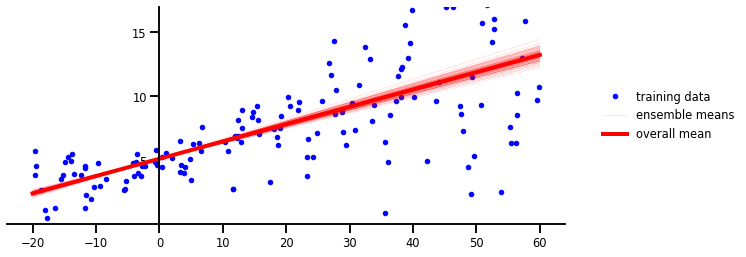

In [271]:
plt.figure(figsize=[10, 4])  # inches
plt.clf();
plt.plot(inputs, outputs, 'b.', label='training data');

avgm = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred)
  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(inputs_tst, avgm/len(output_preds), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/ensemble_with_epistemic_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, we can see there is variation among the ensemble means. However, the variation is not as spread as the ensemble means of the BNN which captures epistemic uncertainty (see Bayesian Neural Networks: Capturing Epistemic Uncertainty).

### Ensemble: Epistemic Uncertainty with Random Weight Initialization AND Bootstrapping

We can combine random weight initialization and bootstrapping in the same ensemble. In the below code, we create 100 bootstrapped samples, define 100 randomly-initialized models, and train each model on a single boostrapped sample. 

In [272]:
data = np.transpose(np.array([inputs[:,0], outputs]))
boot_sample_list = []
for i in range(n_models):
    boot_sample_list.append(data[np.random.choice(n, size = n, replace = True)])
    
model_list = []
for i in range(n_models):
    if i % 5 == 0:
        print(f'Training model {i}...')
    
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(2, name = 'dense_1'),
      tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
    model.fit(boot_sample_list[i][:,0], boot_sample_list[i][:,1], epochs=1000, verbose=False);
    
    model_list.append(model)

Training model 0...
Training model 5...
Training model 10...
Training model 15...
Training model 20...
Training model 25...
Training model 30...
Training model 35...
Training model 40...
Training model 45...
Training model 50...
Training model 55...
Training model 60...
Training model 65...
Training model 70...
Training model 75...
Training model 80...
Training model 85...
Training model 90...
Training model 95...


Next, we generate outputs from the ensemble and average the whole ensemble's outputs, resulting in the overall mean. 

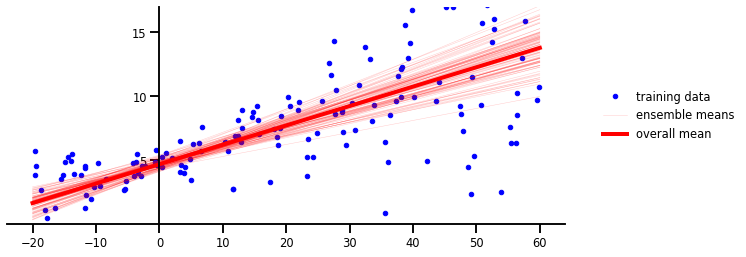

In [273]:
plt.figure(figsize=[10, 4])
plt.clf();
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst) for model in model_list]
avgm = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred)
  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(inputs_tst, avgm/len(output_preds), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/ensemble_with_epistemic_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, we can see that the ensemble means are more varied than the previous ensemble where we only used random weight initializations. However, the ensemble means are still less varied than the BNN that captures epistemic uncertainty. 

### Ensemble: Aleatoric AND Epistemic Uncertainty with Random Weight Initialization

In [274]:
model_list = []
for i in range(n_models):
    if i % 5 == 0:
        print(f'Training model {i}...')
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(2, name = 'dense_1'),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                               scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
    model.fit(inputs, outputs, epochs=1000, verbose=False);
    
    model_list.append(model)

Training model 0...
Training model 5...
Training model 10...
Training model 15...
Training model 20...
Training model 25...
Training model 30...
Training model 35...
Training model 40...
Training model 45...
Training model 50...
Training model 55...
Training model 60...
Training model 65...
Training model 70...
Training model 75...
Training model 80...
Training model 85...
Training model 90...
Training model 95...


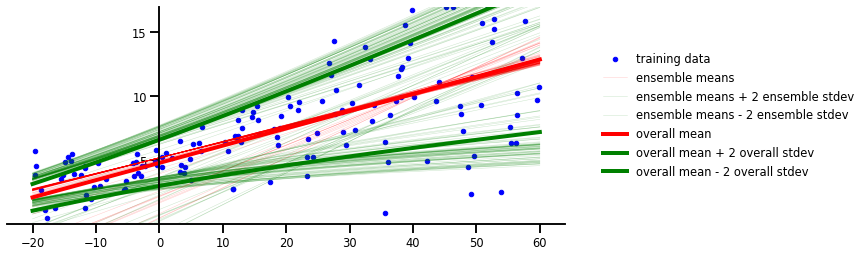

In [275]:
plt.figure(figsize=[10, 4]) 
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst) for model in model_list] # Make an ensemble of predictions, acts like 100 different models
avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())

  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
  avgs += s
plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/ensemble_with_aleatoric_AND_epistemic_AND_rand_weight_init_uq_predictions.png', bbox_inches='tight', dpi=300)

The above plot shows that we quantify the epistemic uncertainty using ensembling while also capturing the aleatoric uncertainty by modeling the outputs of each model as a distribution. However, the epistemic uncertainty (represented by variance in ensemble means) is very small and doesn't represent the true epistemic uncertainty. On the other hand, the model correctly captures the aleatoric uncertainty inherent to the data, as represented by the overall mean $\pm$ 2 overall stdev. 

Now, let's see what happens when we use bootstrapping as well.

### Ensemble: Aleatoric AND Epistemic Uncertainty with Random Weight Initialization and Bootstrapping

In the below code, we create 100 bootstrapped samples, define 100 randomly-initialized models with each output modeled as a Gaussian, and train each model on a single bootstrapped sample. 

In [276]:
data = np.transpose(np.array([inputs[:,0], outputs]))
boot_sample_list = []
for i in range(n_models):
    boot_sample_list.append(data[np.random.choice(n, size = n, replace = True)])

model_list = []
for i in range(n_models):
    if i % 5 == 0:
        print(f'Training model {i}...')
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(2, name = 'dense_1'),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                               scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
    model.fit(boot_sample_list[i][:,0], boot_sample_list[i][:,1], epochs=1000, verbose=False);
    
    model_list.append(model)

Training model 0...
Training model 5...
Training model 10...
Training model 15...
Training model 20...
Training model 25...
Training model 30...
Training model 35...
Training model 40...
Training model 45...
Training model 50...
Training model 55...
Training model 60...
Training model 65...
Training model 70...
Training model 75...
Training model 80...
Training model 85...
Training model 90...
Training model 95...


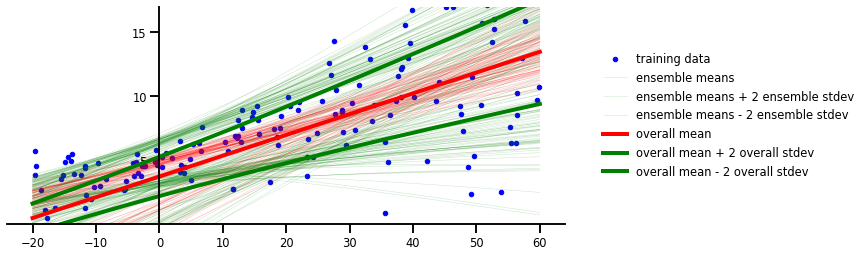

In [277]:
plt.figure(figsize=[10, 4])
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst) for model in model_list] # Make an ensemble of predictions, acts like 100 different models
avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())

  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
  avgs += s

plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/ensemble_with_aleatoric_AND_epistemic_AND_rand_weight_init_AND_bootstrapping_uq_predictions.png', bbox_inches='tight', dpi=300)

In the above plot, we can see that the ensemble means are much more varied than the previous ensemble where we only used random weight initialization. However, it is somewhat too varied. For example, look at the ensemble means that intersect close to $input = 0$. Those ensemble means are not representative of the true epistemic uncertainty because they do not represent a correct model of the data. In simple terms, those ensemble means do not run through the whole training dataset. Why is this? Well, it is likely due to those ensemble means being output from models whose bootstrapped training data was skewed towards data points with $inputs > 10$. This would cause those models to learn to only intersect through those data points. We can investigate this by looking at the distribution of the bootstrapped sample input means, minimum values, and maximum values, which is done below:

In [278]:
input_mean_list = []
input_min_list = []
input_max_list = []
for i in range(n_models):
    input_min_list.append(np.min(boot_sample_list[i][:,0]))
    input_max_list.append(np.max(boot_sample_list[i][:,0]))
    input_mean_list.append(np.mean(boot_sample_list[i][:,0]))

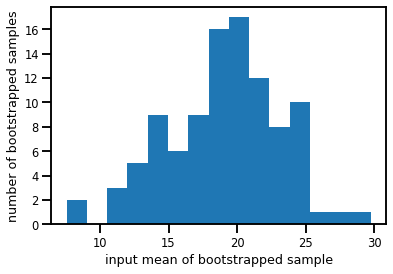

In [279]:
plt.hist(input_mean_list, bins = 15);
plt.xlabel('input mean of bootstrapped sample');
plt.ylabel('number of bootstrapped samples');

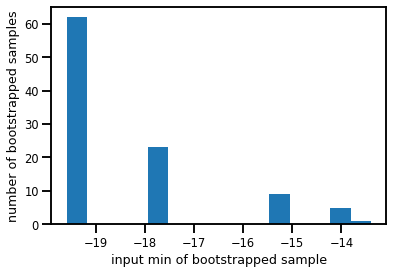

In [280]:
plt.hist(input_min_list, bins = 15);
plt.xlabel('input min of bootstrapped sample');
plt.ylabel('number of bootstrapped samples');

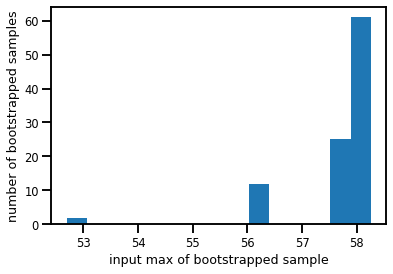

In [281]:
plt.hist(input_max_list, bins = 15);
plt.xlabel('input max of bootstrapped sample');
plt.ylabel('number of bootstrapped samples');

The above distribution shows that there are some outliers in terms of the input means in the mid 20s. This could explain the prior observation. 

### Practical Applications of Ensembling

Ensembling has both pros and cons. In terms of its advantages, ensembling produces high-quality uncertainty quantification results, as demonstrated by the literature on it. Additionally, models in an ensemble allow for parallel training. 

The main disadvantage of ensembling, however, is that it requires immense computational resources because $n$ models need to be trained. This can be a limiting factor when dealing with large models and lots of training data. Another disadvantage is that, in order to quantify the uncertainty, forward passes through each model in the ensemble are required. Thus, if a model is large, say billions of parameters, then making those forward passes will take longer. In real-time tasks, such as autonomous driving, this may not be feasible. 

In the following example situations, ensembling could be a feasible UQ method:

- Suppose we have a small amount of training data and a model with a low number of parameters. In this case, ensembling would be a great method for UQ because the amount of training data and size of the model does not require immense computational resources. 

- Suppose that we have a large amount of computational resources and the task is not time-sensitive. In this case, ensembling would work well because we are not limited computationally, which is the main disadvantage of ensembling.

In the following example situation, ensembling would not be a good choice for UQ:

- Suppose we have a model with a billion parameters, our training data is high-resolution image data, and we have limited GPU resources. In this case, ensembling would not be feasible. Since the model has a billion parameters, we have to store those parameters in the VRAM of the GPUs, so we either need many GPUs or a GPU with enough VRAM for that many parameters to fit. This doesn't even take into account that VRAM usage will increase when training occurs because the training data will be processed through the VRAM. 

## Dropout

Another method for uncertainty quantification uses dropout layers. A dropout layer sets the values of a previous layers' nodes to 0. The nodes chosen to be set to 0 are determined via a Bernoulli random variable with a dropout probability $p$. Dropout layers are usually placed after dense layers in neural networks. When a forward pass is made through the network, a random set of nodes' values are set to 0 via the dropout layers. The backwards pass through the network uses those same node values that were set to 0. The uncertainty quantification happens when we evaluate the model after training. After training, we make multiple forward passes, with dropout active, through the network, resulting in multiple outputs. Each of these outputs correspond to a randomly chosen set of nodes that have not been dropped. Thus, in theory, each forward pass acts as a different model in an ensemble because each forward pass goes through a different set of weights. 

### Monte-Carlo (MC) Dropout

In the below code cell, we create a small neural network with a single input and a Gaussian distribution, with a parameterized mean and standard deviation, as output. The hidden layers are a dense layer with 16 nodes followed by a dropout layer with a dropout probability of 0.2. The dropout layer is then followed by a dense layer with 2 nodes, corresponding to the mean and standard deviation which defines the Gaussian distribution that follows.

In [288]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, name = 'dense_1'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(inputs, outputs, epochs=1000, verbose=False);

After training, we make $n$ forward passes through the network. The output will be $n$ Gaussian distributions. 

In [289]:
output_preds = [model(inputs_tst, training = True) for _ in range(n_models)]

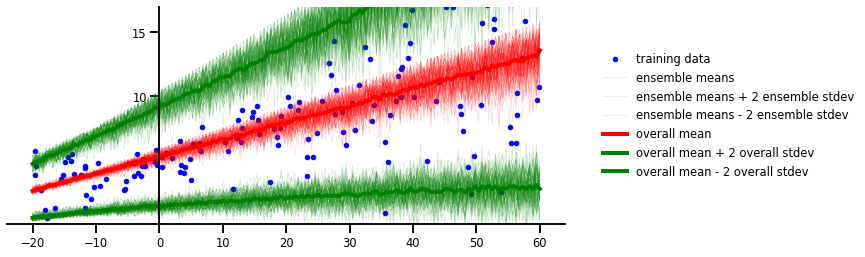

In [290]:
plt.figure(figsize=[10, 4])
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst, training = True) for _ in range(n_models)] # Make an ensemble of predictions, acts like 100 different models
avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())

  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  
  avgm += m
  avgs += s
    
plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/mcdropout_0.2_with_aleatoric_AND_epistemic.png', bbox_inches='tight', dpi=300)

In the above example, we used a dropout probability of 0.2, but this was arbitrarily chosen. What happens when we change this to a different probability, say 0.5?

In [291]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, name = 'dense_1'),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(inputs, outputs, epochs=1000, verbose=False);

After training, we make $n$ forward passes through the network. The output will be $n$ Gaussian distributions. 

In [292]:
output_preds = [model(inputs_tst, training = True) for _ in range(n_models)]

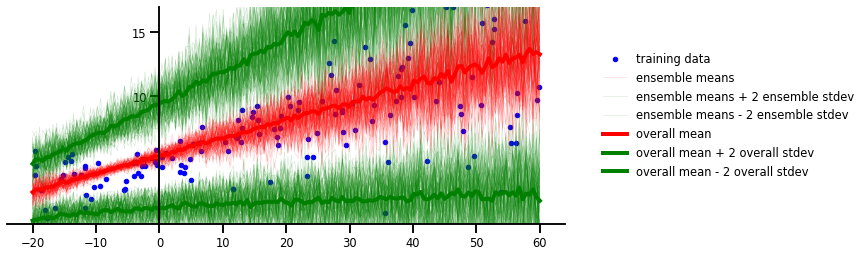

In [293]:
plt.figure(figsize=[10, 4])
plt.plot(inputs, outputs, 'b.', label='training data');

output_preds = [model(inputs_tst, training = True) for _ in range(n_models)] # Make an ensemble of predictions, acts like 100 different models
avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, output_pred in enumerate(output_preds):
  m = np.squeeze(output_pred.mean())
  s = np.squeeze(output_pred.stddev())

  plt.plot(inputs_tst, m, 'red', alpha = 0.2, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'green', linewidth=0.5, alpha = 0.2, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  
  avgm += m
  avgs += s
    
plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/mcdropout_0.5_with_aleatoric_AND_epistemic.png', bbox_inches='tight', dpi=300)

We can see that changes in the dropout probability can have a large impact on the results. Now imagine that we have many dropout layers in the model, how do we choose what to set each dropout probability to? This is the main issue with MC-dropout and why ensembling and bayesian neural networks often outperform it.

### Concrete Dropout

Concrete dropout solves the prior issue with MC-dropout. In Concrete Dropout, we optimize the parameters of the distributions that determine the dropout. However, since the Bernoulli distribution doesn't allow for the reparameterization trick, a concrete distribution relaxation is used. Specifically, we use the following relaxation:

<font size = "3"> $\tilde{z} = sigmoid(\frac{1}{t} * (\log p - \log(1-p) + \log u - \log (1-u)))$ </font>

where $p$ is the dropout probability, $t$ is a temperature, and $u$ is sampled from a uniform distribution between 0 and 1. Given this form, the functional relation bettween $\tilde{z}$ and $u$ is differentiable with respect to $p$. With Concrete Dropout, this distribution determines the nodes that are dropped out. 



Concrete Dropout was introduced by Gal et. al (https://arxiv.org/pdf/1705.07832.pdf). The below example uses code from https://github.com/aurelio-amerio/ConcreteDropout to perform Concrete Dropout on my data. 

In the below interactive plot, you can see how the values of $u$ and $t$ affect the concrete distribution:

In [5]:
p = np.linspace(start = 0.001, stop = .9999, num = 100)

plt.figure(figsize=[7,4]); 
def concrete(u, t):
    z = tf.math.sigmoid((1/t) * (np.log(p) - np.log(1-p) + np.log(u) - np.log(1-u)));
    plt.plot(p, z, color='C0');
    plt.show()
    
interact(concrete, u=FloatSlider(min=0, max=1, step=0.1, value=0.5), t = FloatSlider(min=0, max=1, step=0.1, value=0.1));

<Figure size 504x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.5, description='u', max=1.0), FloatSlider(value=0.1, description='t'…

Concete Dropout uses the below heteroscedastic loss funtion in order to optimize the model parameters. In the below cell, we can see this loss function. The loss takes into account both the mean and the log variance that is output by the model.

In [295]:
@tf.function
def heteroscedastic_loss(y_true, y_pred):
    D = y_pred.shape[-1]//2
    mean = y_pred[:, :D]
    log_var = y_pred[:, D:]
    precision = tf.math.exp(-log_var)
    return tf.math.reduce_sum(precision * (y_true - mean)**2. + log_var)

In [296]:
def build_cd_model(input_values, input_shape):
    # compute the regularisation values
    Ns = input_values.shape[0]
    wr = get_weight_regularizer(Ns, l=1e-2, tau=1.0)
    dr = get_dropout_regularizer(Ns, tau=1.0, cross_entropy_loss=False)

    input_layer = tf.keras.layers.Input(input_shape, name="inputs")

    dense1 =tf.keras.layers.Dense(16)
    x = dense1(input_layer)
    x = tf.keras.layers.Activation("relu", name="activation_1")(x)

    dense2 = tf.keras.layers.Dense(32)
    x = ConcreteDenseDropout(dense2, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)
    x = tf.keras.layers.Activation("relu", name="activation_2")(x)
    
    dense3 = tf.keras.layers.Dense(32)
    x = ConcreteDenseDropout(dense3, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)
    x = tf.keras.layers.Activation("relu", name="activation_3")(x)

    dense_mean = tf.keras.layers.Dense(1)
    mean = ConcreteDenseDropout(dense_mean, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)

    dense_logvar = tf.keras.layers.Dense(1)
    logvar = ConcreteDenseDropout(dense_logvar, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)

    concat = tf.keras.layers.Concatenate(axis=-1)([mean, logvar]) 
    output_layer = tf.keras.layers.Activation("linear", name="out")(concat)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="regression_model")

    model.compile(loss=heteroscedastic_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=.001))
    model.summary()

    return model

In [297]:
epochs = 1000
input_shape = (1,)
model = build_cd_model(inputs, input_shape)
hist = model.fit(inputs, outputs, epochs=epochs, verbose=0)

Model: "regression_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_649 (Dense)               (None, 16)           32          inputs[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16)           0           dense_649[0][0]                  
__________________________________________________________________________________________________
concrete_dense_dropout_8 (Concr (None, 32)           545         activation_1[0][0]               
___________________________________________________________________________________

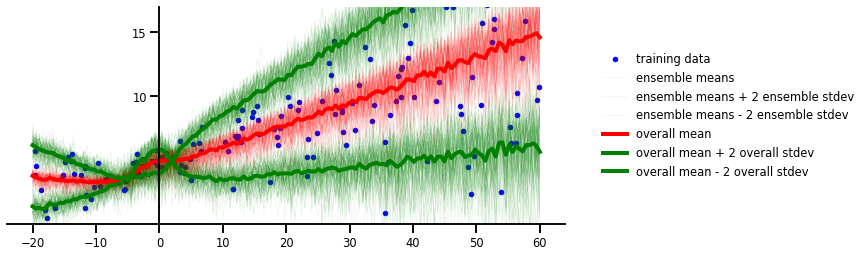

In [298]:
plt.figure(figsize=[10, 4]) 
plt.plot(inputs, outputs, 'b.', label='training data');
output_preds = [model(inputs_tst, training = True) for _ in range(100)]

avgm = np.zeros_like(inputs_tst[..., 0])
avgs = np.zeros_like(inputs_tst[..., 0])
for i, _ in enumerate(output_preds):
  m = np.squeeze(output_preds[i][:,0])
  s = np.squeeze(output_preds[i][:,1])
  
  plt.plot(inputs_tst, m, 'red', alpha = 0.1, label='ensemble means' if i == 0 else None, linewidth=0.5)
  plt.plot(inputs_tst, m + 2 * s, 'green', linewidth=0.5, alpha = 0.1, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
  plt.plot(inputs_tst, m - 2 * s, 'green', linewidth=0.5, alpha = 0.1, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  
  avgm += m
  avgs += s
    
plt.plot(inputs_tst, avgm/len(output_preds), c = 'red', label='overall mean', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) + 2 * (avgs/len(output_preds)), c = 'green', label='overall mean + 2 overall stdev', linewidth=4)
plt.plot(inputs_tst, avgm/len(output_preds) - 2 * (avgs/len(output_preds)), c = 'green', label='overall mean - 2 overall stdev', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('images/concretedropout_with_aleatoric_AND_epistemic.png', bbox_inches='tight', dpi=300)

### Practical Applications of Dropout

Since MC-dropout does not perform well in UQ tasks, it is not likely that you should deploy it. However, multiple research papers have used MC-dropout when comparing other UQ methods. These research papers show that MC-dropout is nearly always outperformed by other methods, such as ensembling. 

Concrete dropout, however, does have some pratical applications. Since it solves the main issue with MC-dropout, it's reasonable to use it when attempting UQ. 

In the following example, it may be useful to use concrete dropout: 

- Suppose you have limited computational resources, a large model, and lots of training data. Since such a situation doesn't allow for ensembling, concrete dropout could be used to perform UQ. This is because concrete dropout requires training a single model and does not need to make passes through multiple models in parallel. 

## Gaussian Processes

In Gaussian Processes (GPs), we don't sample paramters as is done in bayesian neural networks, but instead sample functions that model our data. Gaussian processes (GPs) are defined as a collection of random variables where the joint distribution of any subset of the variables is a multivariate Gaussian. The multivariate Gaussian is defined by a mean function and a covariance function (kernel).

The kernel is the most important part of GPs because it defines the form of the functions that can be sampled. Kernels measure the similarity between two inputs and outputs a single value. Some of the most common kernels are the RBF, periodic, and linear kernels. They are defined as follows:

- RBF: <font size = "3"> $\sigma^2 exp{(-\frac{||t-t^\prime||^2}{2l^2})}$ </font> with parameters for variance $\sigma$ and length $l$.
- Periodic: <font size = "3"> $\sigma^2 exp{(-\frac{2\sin^2(\pi|t-t^\prime|/p)}{l^2})}$ </font> with parameters for variance $\sigma$, length $l$, and periodicity $p$.
- Linear; <font size = "3"> $\sigma^2_b + \sigma^2 (t-c)(t^\prime - c)$ </font> with parameters for variance $\sigma$ and $\sigma_b$ and an offset $c$.

Each of these kernels will affect the forms of functions that we sample from our GP so it is important to select one that is correct for your data. For example, if you have data that you believe to originate from some linear function, you should use the linear kernel. 

Now that you have the background of GPs, let's go over how GPs can generate data!

If we are given some observed data, $(x,y)$ where $x$ are inputs and $y$ are outputs, with implied latent function values $f$, we can write a generative process as:
- $f \sim GP(\mu(x), k(x,x^\prime))$ where $\mu$ is our mean function and $k$ is our kernel function.
- $y_i \sim \mathcal{N}(f(x_i), \sigma)$ for $i = 1,...,N$.

GPs assume inputs are generated from some function, $f$, and the outputs of $f$ have noise, $\epsilon$, added to them. Thus, we have the following relationship, $y_i = f(x_i) + \epsilon$, where $x_i$ are our inputs and $y_i$ are the outputs in our observations. The $f$ in the previous equation is the function that we sample from our GP. 

We can now build a GP! The below code was adapted from TensorFlow's guide on GPs for regression: https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP.

In [299]:
def build_gp(bias_amplitude, slope_amplitude, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.Linear(bias_amplitude, slope_amplitude) 

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=inputs,
      observation_noise_variance=observation_noise_variance)

In the above cell, we create a function that defines a GP that has a linear kernel. 

The first step is to specify what kernel that we want to use and what parameters that we want to optimize. We choose to use the linear kernel and we specify two parameters: bias_amplitude and slope_amplitude. These two parameters correspond to $\sigma$ and $\sigma_b$ in the earlier definition of the linear kernel. We could specify a shift parameter, $c$, but we won't do that in this example. 

The second step is to define the actual GP. We pass the kernel that we defined to the GP, alongside the training data inputs and an observation noise variance. The observation noise variance refers to $\epsilon$ in the earlier $y_i = f(x_i) + \epsilon$ equation. By specifying that parameter, we can optimize it. 

Next, we can place priors on the GPs parameters and write the joint distribution of the parameters and observed data.

In [300]:
# Write the joint distribution of the HPs and observed data
gp_joint_model = tfd.JointDistributionNamed({
    'bias_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'slope_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

Now we can sample from the prior GP and take the log probability of the samples.

In [301]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)
print(f'log probability of samples: {lp.numpy()}')

log probability of samples: -4.932301989739373


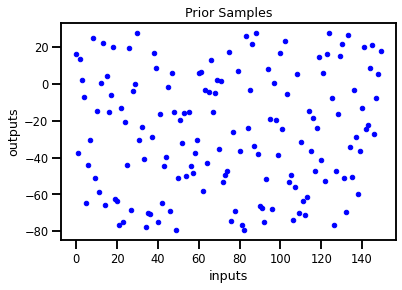

In [302]:
plt.plot(list(range(150)), x['observations'], 'b.')
plt.xlabel('inputs')
plt.ylabel('outputs')
plt.title('Prior Samples')

plt.savefig('images/gp_prior_samples.png')
plt.show()

In the above plot, we can see that our samples are quite non-informative and demonstrate no relationship between inputs and outputs. Thus, we need to optimize the parameters of the GP so that the samples that we generate are representative of our training data. We will do this by finding the parameter values with the highest posterior probability. 

Let's define a variable for each parameter and constrain them to be positive:

In [303]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

# Create a trainable parameter for the amplitude HP of ExponentiatedQuadratic
bias_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='bias_amplitude',
    dtype=np.float64)

# Create a trainable parameter for the length HP of ExponentiatedQuadratic
slope_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='slope_amplitude',
    dtype=np.float64)

# Create a trainable parameter for the noise variance used to create the training data
observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [bias_amplitude_var,
                       slope_amplitude_var,
                       observation_noise_variance_var]]

We'll use the following loss function to condition the model on our training data:

In [304]:
def target_log_prob(bias_amplitude, slope_amplitude, observation_noise_variance):
  return gp_joint_model.log_prob({
      'bias_amplitude': bias_amplitude,
      'slope_amplitude': slope_amplitude,
      'observation_noise_variance': observation_noise_variance,
      'observations': outputs
  })

Now we are ready to optimize the GP's parameters:

In [305]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(bias_amplitude_var, slope_amplitude_var, observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('bias_amplitude: {}'.format(bias_amplitude_var._value().numpy()))
print('slope_amplitude: {}'.format(slope_amplitude_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
bias_amplitude: 2.9004861191868625
slope_amplitude: 0.20828726984118642
observation_noise_variance: 9.997746476394122


After training, we can see the optimized parameters. Now let's generate samples using our GP!

In [306]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-20, 60, 1000, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.Linear(bias_amplitude_var, slope_amplitude_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=np.float64(inputs_tst),
    observation_index_points=np.float64(inputs),
    observations=np.float64(outputs),
    observation_noise_variance = observation_noise_variance_var,
    predictive_noise_variance=0)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 100
samples = gprm.sample(num_samples)

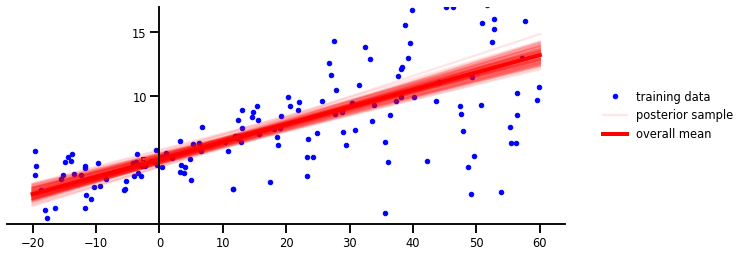

In [307]:
# Plot the training data and the surrogate posterior samples.
plt.figure(figsize=(10, 4))

plt.plot(inputs, outputs, 'b.', label='training data')
avgm = np.zeros_like(inputs_tst[..., 0])
for i in range(num_samples):
  m = np.squeeze(samples[i, :])
  plt.plot(inputs_tst, samples[i, :], c='r', alpha = 0.1,
           label='posterior sample' if i == 0 else None)
  avgm += m

plt.plot(inputs_tst, avgm/len(samples), c = 'red', label='overall mean', linewidth=4)
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('images/gp_posterior_samples.png')

We can see that the posterior samples allow us to capture the epistemic uncertainty!

### Practical Applications of GPs

As we've seen in this section, GPs are able to approximate the epistemic uncertainty. Like other methods, GPs have advantages and disadvantages.

Advantages:
- Are a strong tool for solving both regression and classification problems in a probalistic manner. 
- Are able to approximate epistemic uncertainty.
- Allow us to incorporate prior knowledge into the model and sample functions from the posterior.
- Are very versatile since different kernels can be used. 
- Can also be layered, similar to the layers of a neural network. Thus, more powerful GPs can be created by stacking them. 

Disadvantages:
- Use all data to make a prediction. So, if you trained on lots of training data, and now you want to make predictions for many testing data points, the GP will use every single one of those data points. 
- Do not perform well with data that is high-dimensional.
- Scalability is an open problem with GPs.
- Difficult to approximate aleatoric uncertainty with GPs.

In the following example situations, a GP would be a good option to implement:

- Suppose you have a limited amount of low-dimensional data. Given this situation, GPs would be a great option because you would not run into the scalability issue with GPs since the data is limited and low-dimensional. 
- Suppose you have prior knowledge about the type of function, say linear, that your data is generated from. Then, you could incorporate this prior knowledge into a GP by using a linear kernel. 

## Normalizing Flows

Images and notes for this section are from Marcus A. Brubaker and Ullrich Kothe's presentation on normalizing flows at CVPR 2021. The slides can be found here: https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf. </font> 

A normalizing flow transforms a complex distribution into a simpler distribution (or vice versa) through a series of invertible, differentiable functions. 

In the below image, we can see a diagram of what a normalizing flow does. We can begin with a multi-modal distribution, $p_x(x)$. Then, we can use a composition of invertible and differentiable functions, $f = f_4 \circ f_3 \circ f_2 \circ f_1$, in order to transform it to a simpler distribution, $p_z(f(x))$. 

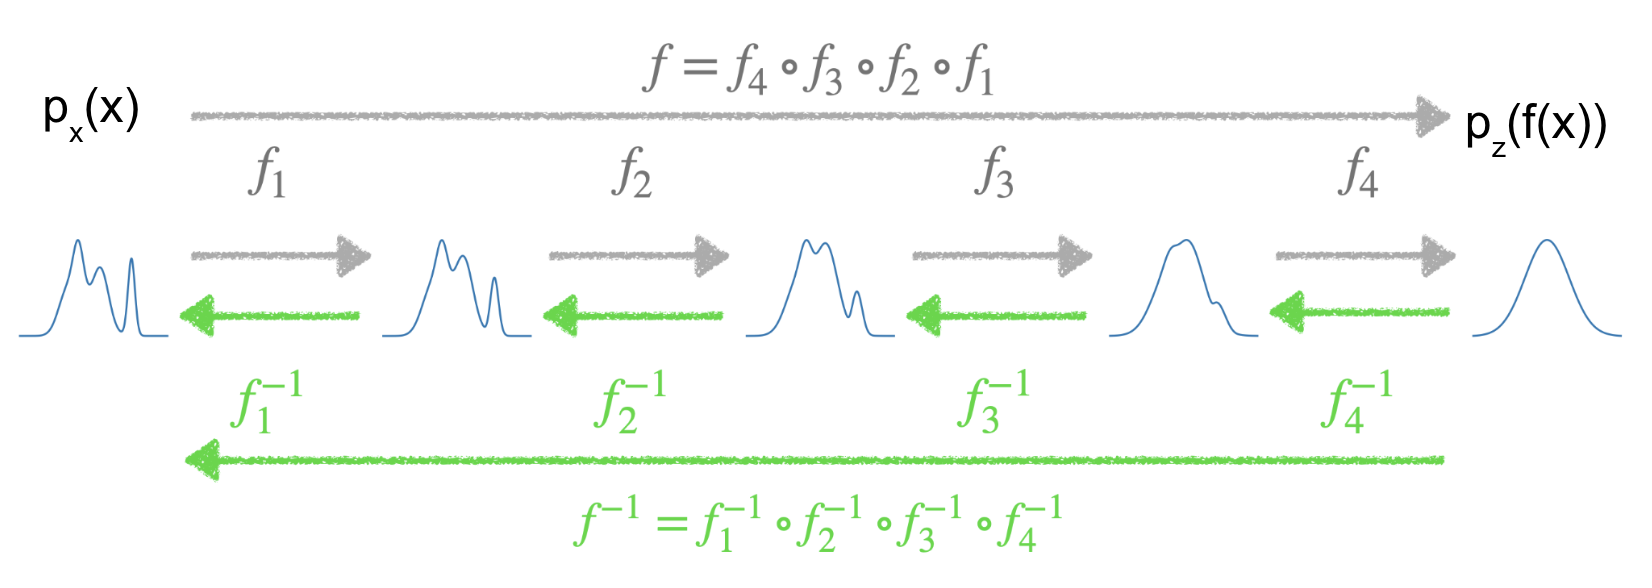

In [223]:
Image(filename='images/normalizing_flow_example.png', width = 700, height = 300) 

In order to represent $p_x(x)$ in terms of $p_z(z)$ and $f(x)$, we use the following equation:

$p_x(x) = p_z(f(x))|det Df(x)|$

where $f(x)$ is the invertible, differentiable function, $Df(x)$ is the Jacobian of $f(x)$, and $|det Df(x)|$ is the volume correction term. The volume correction term ensures that each probability density integrates to 1.

With the normalizing flow, we can sample $z \sim p_z(.)$ and then compute $x$ via $x = f^{-1}(z)$.

So, why is this useful?

Well, suppose we want to generate novel images of trees and we have $n$ images of trees in a training set. We can think of the $n$ images of trees as a multi-modal, high-dimensional distribution. Then, we can use a normalizing flow to transform the distribution of tree images, $p_x(x)$, to Gaussian noise, $p_z(z)$. Once we determine $f(x)$ and $f^{-1}(z)$, we will be able to sample from Gaussian noise, pass those samples through $f^{-1}(z)$ and generate novel images of trees!  

If you have studied Variational Autoencoders (VAEs), you can see the similarities between those and normalizing flows. However, VAEs just train to find a lower bound on the log likelihood, while normalizing flows optimize for the exact log-likelihood. Therefore, normalizing flows allow for exact posterior inference while VAEs allow for only approximate posterior inference.

Now that you have some background on normalizing flows, let's put what you've learned to work in an example.

We'll begin by creating some synthetic data.

In [321]:
n = 10000
noise_ratio = 0.05
std = 0.1

x1_1 = np.random.normal(loc = 1, scale = 1, size = int(n/2))
x1_2= np.random.normal(loc = 4, scale = 1, size = int(n/2))
x1_complete = np.append(x1_1, x1_2)

x2_1 = np.random.normal(loc = 5, scale = 1, size = int(n/2))
x2_2= np.random.normal(loc = 2, scale = 1, size = int(n/2))
x2_complete = np.append(x2_1, x2_2)

x_target = np.transpose(np.stack([x1_complete, x2_complete]))

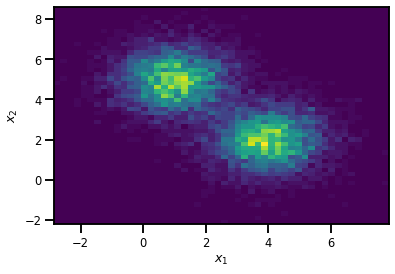

In [322]:
plt.hist2d(x1_complete, x2_complete, bins = 50);
plt.xlabel(r'$x_1$');
plt.ylabel(r'$x_2$');

In the above code, we create two random variables: $x_1$ and $x_2$. Both random variables are bi-modal Gaussian distributions. The above plot shows the joint probability density of $x_1$ and $x_2$.

We will treat $p(x_1, x_2)$ as $p_x(x)$ in our previous normalizing flow definition. Now, we will attempt to create a normalizing flow between $p_x(x)$ and a 2-dimensional Gaussian which will act as $p_z(z)$ in our previous definition. The below code is an adaptation of this example: https://github.com/bgroenks96/normalizing-flows/blob/master/normalizing-flows-intro.ipynb.

We begin by creating $p_z(z)$ which will be a 2-dimensional Gaussian. The means and standard deviations of this Gaussian will be parameters. 

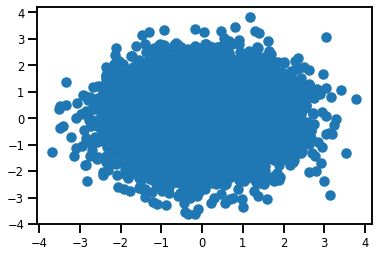

In [323]:
# Surrogate Posterior
# 2D Gaussian with 2 means (mu_1, mu_2) and 2 variances (sigma_1, sigma_2)
N = 10000
variational_mean = tf.Variable(tf.zeros((N,2)))
variational_log_scale = tf.Variable(tf.zeros((N,2)))
variational_density = tfp.distributions.MultivariateNormalDiag(
    loc=variational_mean,
    scale_diag=tfp.util.DeferredTensor(variational_log_scale, tf.math.exp),
)
samples = variational_density.sample()
_ = plt.scatter(samples[:,0], samples[:,1])

In the above plot, we see what $p_z(z)$ looks like before any transformations and training.

Now, we will will make the transformations that define the normalizing flow. We will use 15 planar transformation functions. Each planar function has 5 parameters that will be optimized during our training process.

In [324]:
# construct planar flow
num_steps = 15 # number of transformations
# each Planar transform has 5 params
flow = Flow.uniform(num_steps, lambda i: affine.Planar())
# create trainable parameters;
# planar flow requires parameters to be given on the forward pass
flow_params = flow.create_variables(x_target.shape)

Now that we've defined $p_x(x)$, $p_z(z)$, and $f(x)$, we can optimize the flow.

On each training iteration, we draw $N$ samples $z \sim p_z(z)$ and pass these samples through our flow function $f^{-1}(z)$. Since we are trying to make the output of $f^{-1}(z)$ match samples from $p_x(x)$, we will calculate the mean squared error between the samples from $f^{-1}(z)$ and $p_x(x)$. A scaled KL divergence term is added to the loss and the loss is then used to perform gradient descent on the parameters of the flows.

We will train for 100 iterations with the Adam optimizer with a learning rate of 1e-2.

In [325]:
# MLE training
trainable_variables = [variational_mean,variational_log_scale,*flow_params]
optimizer = tf.keras.optimizers.Adam(lr=1.0E-2, amsgrad=True)
N_iter = 500
with tqdm(total=N_iter) as prog:
    for i in range(N_iter):
        with tf.GradientTape() as gt:
            # draw N samples from p_z(z)
            x_0 = variational_density.sample()
            # make a forward pass through the flow f^-1(x_0)
            x_k, ldj = flow(x_0, *flow_params)
            # use MSE as negative log likelihood estimate
            nll = tf.math.reduce_mean((x_k - x_target)**2)
            # compute the KL divergence analytically between
            # our initial variational density and the standard normal (prior)
            kld = kl_divergence_normal(x_0, x_k,
                                       variational_mean,
                                       0.0,
                                       variational_log_scale,
                                       0.0,
                                       ldj=ldj)
            # loss is NLL + the scaled KL divergence;
            # KLD is annealed to prevent early collapse to the prior density
            loss = nll + 1.0/(N_iter-i+1.)*kld
        grads = gt.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads,trainable_variables))
        prog.update(1)
        prog.set_postfix({'loss': loss.numpy(), 'mse': nll.numpy()})

100%|██████████| 500/500 [05:19<00:00,  1.56it/s, loss=4.86, mse=1.08]  


After training, we can look at how the optimized flow transforms the data at each step. Since we have 15 functions that make up our flow, we'll have 15 plots:

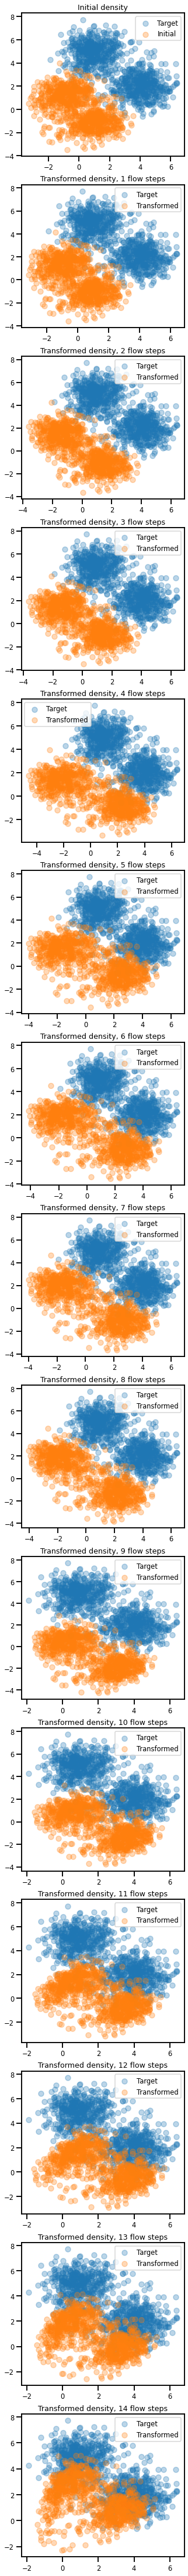

In [326]:
x_0 = variational_density.sample()
xs, ldj = flow(x_0, *flow_params, return_sequence=True)
fig, axs = plt.subplots(num_steps, 1, figsize=(5, 8*10))
axs[0].scatter(x_target[::10,0],x_target[::10,1],alpha=0.3)
axs[0].scatter(xs[0][::10,0],xs[0][::10,1],alpha=0.3)
axs[0].legend(['Target', 'Initial'])
axs[0].set_title('Initial density')
for i in range(1,num_steps):
    axs[i].scatter(x_target[::10,0],x_target[::10,1],alpha=0.3)
    axs[i].scatter(xs[i][::10,0],xs[i][::10,1],alpha=0.3)
    axs[i].legend(['Target', 'Transformed'])
    axs[i].set_title(f'Transformed density, {i} flow steps')

We can see that our training process was able to optimize the flow function parameters in order to transform samples from $p_z(z)$ to mimic samples from $p_x(x)$. Although, the transformed samples don't exactly match $p_x(x)$, if we trained for longer and added more steps, the samples would improve.

### Practical Applications of Normalizing Flows

Advantages:
- Can map a complex distribution to a simpler distribution through a series of invertible, differentiable functions.
- Allows for sampling from an exact PDF. 
- Can be used as a generative model. 

Disadvantages:
- The input and output dimensions must be the same.
- Computing the determinant of the Jacobian needs to be efficient and differentiable. Thus, the choice of flow transformation functions is important. 

In the following example situation, normalizing flows would be a good option:

- Suppose you are given a highly-complex, high-dimensional dataset that you want to generate samples from. Normalizing flows can be used to create an invertible transformation between the distribution of that dataset and a multivariate Gaussian with the same dimensions. This would allow you to sample from the multivariate Gaussian and transform that sample through the learned transformation functions, resulting in samples that are like those from the distribution of the dataset.

## Implicit Quantile Networks

Let me begin with a discussion on quantile regression. Quantile regression is used to estimate the quantile function of a distribution at specific points, ie its inverse CDF. Suppose we have the below regression data.

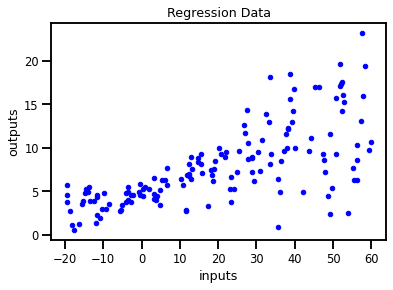

In [327]:
plt.plot(inputs,outputs, 'b.');
plt.xlabel('inputs');
plt.ylabel('outputs');
plt.title('Regression Data');

We assume the output is distributed according to some distribution (in this case, we know that it is Gaussian). Let's analyze the distribution of samples generated from the Gaussian at a certain input. For the sake of the example, let's just assume the output at that input is distributed to a Gaussian with mean 0 and standard deviation 3. Below, we will draw 1000 samples from this distribution and histogram the results.

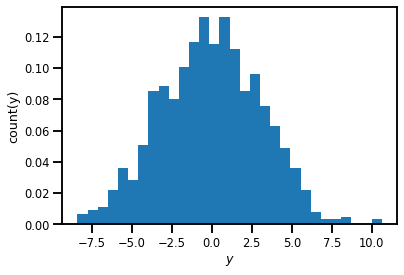

In [328]:
y = np.random.normal(loc = 0, scale = 3, size = (1000,))
count, bins, ignored = plt.hist(y, 30, density = True)
plt.xlabel(r'$y$');
plt.ylabel(r'count(y)');

In the above plot, we can see that the samples are distributed according to a Gaussian. Now, we can calculate the Probability Density Function (PDF) and the Cumulative Distribution Function (CDF) of that distribution of samples.

In [329]:
pdf = count / sum(count)
cdf = np.cumsum(pdf)

Let's see what the PDF and CDF look like:

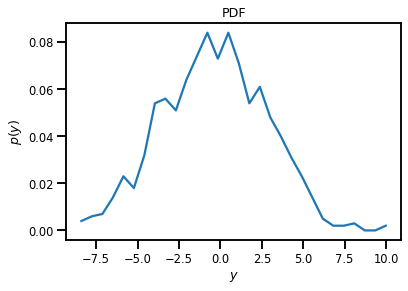

In [330]:
plt.plot(bins[:30], pdf);
plt.xlabel(r'$y$');
plt.ylabel(r'$p(y)$');
plt.title('PDF');

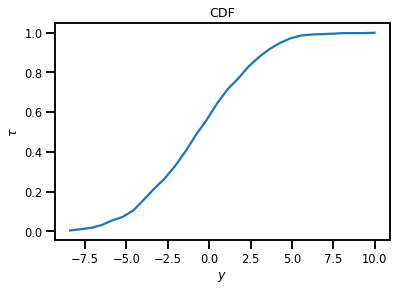

In [331]:
plt.plot(bins[:30], cdf);
plt.xlabel(r'$y$');
plt.ylabel(r'$\tau$');
plt.title('CDF');

Since we've calculated the CDF, we can also plot the inverse of the CDF, or the quantile function. 

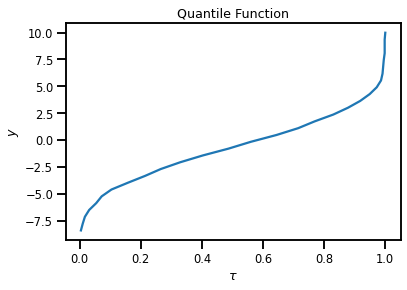

In [332]:
plt.plot(cdf, bins[:30]);
plt.xlabel(r'$\tau$');
plt.ylabel(r'$y$');
plt.title('Quantile Function');

So what is the point of all this? Why is the quantile function so important?

Well, if we have the quantile function, then we can input a multiple quantiles, $\tau$, which will give us multiple $y$ values. Then, we can use these $y$ values to approximate the distribution of $y$, $p(y)$. If we are able to approximate $p(y)$, then we can sample from it! This is why implicit quantile networks are so interesting. Suppose that we have the regression data at the beginning of this section. In that case, we could use an implicit quantile network to estimate $p(y)$ for every $x$ value. Thus, we can capture the aleatoric uncertainty of the data. 

Now that I've given an overview behind the idea of implicit quantile networks, let's build one! The below code is adapted from a notebook by Amedeo Biolatti (https://www.kaggle.com/code/abiolatti/deep-quantile-regression-in-keras). 

We begin by defining our loss function. The loss function is the most important part of an implicit quantile network because it is where the quantiles are incorporated. For more information on the Huber loss, see https://en.wikipedia.org/wiki/Huber_loss.

In [333]:
def huber_loss(quantiles, delta=1e-4):
    quantiles = np.array(quantiles).reshape(-1)
    quantiles.sort()
    quantiles = quantiles.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(y <= pred, tf.float32)
        d = tf.math.abs(y - pred)
        correction = I * (1 - quantiles) + (1 - I) * quantiles
        # huber loss
        huber_loss = tf.math.reduce_sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = tf.math.reduce_sum(tf.math.maximum(0.0, pred[:, :-1] - pred[:, 1:] + 1e-6), -1)
        return huber_loss + q_order_loss
    return _qloss

After defining our loss function, we can define our implicit quantile network. We begin by choosing the quantiles that we want our model to output values for. For example purposes, we choose quantile values of 0.01, 0.25, 0.5, 0.75, and 0.99. Then, we define a neural network with 3 hidden layers and an output layer with 5 nodes. Each of these 5 nodes correspond to one of our quantile values. Thus, when we pass through an input, we will receive 5 values each belonging to a different quantile. For example, we should expect the values output by the 3rd node, which corresponds to a quantile of 0.5, to be the mean of the outputs. 

Now that we defined the model, we can compile the model with the Adam optimizer and our defined Huber loss function and train for 1000 epochs.

In [334]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5)
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=huber_loss(quantiles))
model.fit(inputs, outputs, epochs=1000, verbose=0);
model.summary()

Model: "sequential_1227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_654 (Dense)            (None, 256)               512       
_________________________________________________________________
dense_655 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_656 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_657 (Dense)            (None, 5)                 325       
Total params: 41,989
Trainable params: 41,989
Non-trainable params: 0
_________________________________________________________________


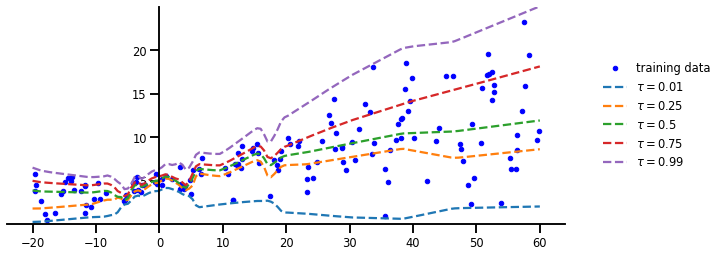

In [335]:
preds = model(inputs_tst)
plt.figure(figsize=[10, 4])  # inches
plt.plot(inputs, outputs, 'b.', label = 'training data')
plt.plot(inputs_tst, preds[:,0], linestyle='--', label = r'$\tau = 0.01$')
plt.plot(inputs_tst, preds[:,1], linestyle='--', label = r'$\tau = 0.25$')
plt.plot(inputs_tst, preds[:,2], linestyle='--', label = r'$\tau = 0.5$')
plt.plot(inputs_tst, preds[:,3], linestyle='--', label = r'$\tau = 0.75$')
plt.plot(inputs_tst, preds[:,4], linestyle='--', label = r'$\tau = 0.99$')

plt.ylim(-0.,25);
plt.yticks(np.linspace(0, 20, 5)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('images/iqn_input_to_output_predictions.png')

The above plot demonstrates that our implicit quantile network was able to learn the quantile functions for the quantile values 0.01, 0.25, 0.5, 0.75, and 0.99. Further, we can see that the model captures the full aleatoric uncertainty inherent to the data. 

### Practical Appliations of IQNs

Advantages:

- Can learn quantile functions which can be used to sample from the true probability density function
- Is able to capture aleatoric uncertainty well
- Can be used as a generative modeling technique
- Makes no assumptions about the distribution of the outputs

Disadvantages:
- Requires an output node for every quantile

In the following situation, an IQN would be a good choice:

- Suppose you are given some regression data that has a large amount of inherent uncertainty and you don't know how the outputs are distributed. Your goal is to estimate the output values at a given quantile (ie .9) for every input. In this case, you could use a IQN to estimate the output values at that quantile value by simply setting the output of the model to be a single quantile corresponding to 0.9. 
